# 个性化推荐

**本项目使用文本卷积神经网络，并使用[`MovieLens`](https://grouplens.org/datasets/movielens/)数据集完成电影推荐的任务。**



推荐系统在日常的网络应用中无处不在，比如网上购物、网上买书、新闻app、社交网络、音乐网站、电影网站等等等等，有人的地方就有推荐。根据个人的喜好，相同喜好人群的习惯等信息进行个性化的内容推荐。比如打开新闻类的app，因为有了个性化的内容，每个人看到的新闻首页都是不一样的。

这当然是很有用的，在信息爆炸的今天，获取信息的途径和方式多种多样，人们花费时间最多的不再是去哪获取信息，而是要在众多的信息中寻找自己感兴趣的，这就是信息超载问题。为了解决这个问题，推荐系统应运而生。

协同过滤是推荐系统应用较广泛的技术，该方法搜集用户的历史记录、个人喜好等信息，计算与其他用户的相似度，利用相似用户的评价来预测目标用户对特定项目的喜好程度。优点是会给用户推荐未浏览过的项目，缺点呢，对于新用户来说，没有任何与商品的交互记录和个人喜好等信息，存在冷启动问题，导致模型无法找到相似的用户或商品。

为了解决**冷启动**的问题，通常的做法是对于刚注册的用户，要求用户先选择自己感兴趣的话题、群组、商品、性格、喜欢的音乐类型等信息，比如豆瓣FM：

## 下载数据集准备
运行下面代码把[`数据集`](http://files.grouplens.org/datasets/movielens/ml-1m.zip)下载下来

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter#支持便捷和快速地计数
import tensorflow as tf

import os
import pickle
import re
from tensorflow.python.ops import math_ops#tensorflow中的图上的节点称之为operations或者ops

In [2]:
from urllib.request import urlretrieve #用于打开URL的可扩展库,将URL表示的网络对象复制到本地文件
from os.path import isfile, isdir
from tqdm import tqdm #Tqdm 是一个快速，可扩展的Python进度条
import zipfile
import hashlib #hashlib模块提供了很多加密的算法

def _unzip(save_path, _, database_name, data_path):
    # 实现类似于c++中私有方法，意味着该方法或属性不应该去调用
    """
    Unzip wrapper with the same interface as _ungzip
    使用与_ungzip相同的接口解压缩包装器
    :param save_path: The path of the gzip files
    :param database_name: Name of database
    :param data_path: Path to extract to
    :param _: HACK - Used to have to same interface as _ungzip
    """
    print('Extracting {}...'.format(database_name))
    with zipfile.ZipFile(save_path) as zf:#ZipFile是主要的类，用来创建和读取zip文件
        zf.extractall(data_path)#将所有文件解压到channel1目录下

def download_extract(database_name, data_path):
    #下载并提取主程序
    """
    Download and extract database
    下载并提取数据库
    :param database_name: Database name
    """
    DATASET_ML1M = 'ml-1m'
    #如果要下载m1数据集，见url和hashcode对应，设定地址文件
    if database_name == DATASET_ML1M:
        url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
        hash_code = 'c4d9eecfca2ab87c1945afe126590906'
        extract_path = os.path.join(data_path, 'ml-1m')
        save_path = os.path.join(data_path, 'ml-1m.zip')
        extract_fn = _unzip #调用私有方法，打开zip保存路径的文件并提取
    
    #提取路径存在就直接返回
    if os.path.exists(extract_path):
        print('Found {} Data'.format(database_name))
        return
    
    #如果不存在对文件在当前位置创建文件夹
    if not os.path.exists(data_path):
        os.makedirs(data_path)
    
    #如果下载文件保存的位置不存在，
    if not os.path.exists(save_path):
        #生成一个动态下载条
        with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Downloading {}'.format(database_name)) as pbar:
            # urlretrieve方法直接将远程数据下载到本地。
            urlretrieve(
                url,
                save_path,
                pbar.hook)
    #python assert 断言句语格式及用法很简单。在没完善一个程序之前，我们不知道程序在哪里会出错，与其让它在运行最崩溃，不如在出现错误条件时就崩溃
    #见下载文件的md5文件与hashcode值相对应进行判定
    #读取文件，并hexdigest()返回摘要，作为十六进制数据字符串值，如果不相等，文件不存在，删除文件重新尝试
    assert hashlib.md5(open(save_path, 'rb').read()).hexdigest() == hash_code,  '{} file is corrupted.  Remove the file and try again.'.format(save_path)

    os.makedirs(extract_path)
    
    #解压缩，对应地址和文件位置
    try:
        extract_fn(save_path, extract_path, database_name, data_path)
    except Exception as err:
        shutil.rmtree(extract_path)  # Remove extraction folder if there is an error
        raise err
    
    #结束
    print('Done.')
    # Remove compressed data
#     os.remove(save_path)

class DLProgress(tqdm):
    """
    Handle Progress Bar while Downloading
    下载时处理进度条
    """
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        """
        A hook function
        在建立网络连接时将被调用一次 之后每个块读取一次。
        :param block_num: A count of blocks transferred so far
        :param block_size: Block size in bytes
        :param total_size: The total size of the file. This may be -1 on older FTP servers which do not return
                            a file size in response to a retrieval request.
        """
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

In [3]:
data_dir = './'
#当前运行文件目录下（相对路径）
download_extract('ml-1m', data_dir) #下载并保存在当前文件夹下

Extracting ml-1m...
Done.


## 先来看看数据

本项目使用的是MovieLens 1M 数据集，包含6000个用户在近4000部电影上的1亿条评论。

数据集分为三个文件：用户数据users.dat，电影数据movies.dat和评分数据ratings.dat。

### 用户数据
分别有用户ID、性别、年龄、职业ID和邮编等字段。

数据中的格式：UserID::Gender::Age::Occupation::Zip-code

- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges:

	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"

- Occupation is chosen from the following choices:

	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"



**数据处理** 

Gender字段：需要将‘F’和‘M’转换成0和1。
Age字段：要转成7个连续数字0~6。
Occupationid职业id保留

In [4]:
#UserID::Gender::Age::Occupation::Zip-code基本的user信息
users_title = ['UserID', 'Gender', 'Age', 'OccupationID', 'Zip-code']
users = pd.read_table('./ml-1m/users.dat', sep='::', names=users_title, engine = 'python')
#sep='::',间隔符
#pd.read_table读取dat文件
users = users.filter(regex='UserID|Gender|Age|JobID')

In [5]:
gender_map = {'F':0, 'M':1}
users["Gender"] = users["Gender"].map(gender_map)
#map()是python 自带的方法, 可以对df某列内的元素进行操作, 我个人最常用的场景就是有toward_dict的映射关系 ,为df中的toward匹配出结果,
age_map = {val:ii for ii,val in enumerate(set(users['Age']))} #对应key-value值来源于
#enumerate函数用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引索引
users['Age'] = users['Age'].map(age_map)


In [6]:
users.head()

,UserID,Gender,Age
0,1,0,0
1,2,1,5
2,3,1,6
3,4,1,2
4,5,1,6


可以看出UserID、Gender、Age和Occupation都是类别字段，其中邮编字段是我们不使用的。

### 电影数据
分别有电影ID、电影名和电影风格等字段。

数据中的格式：MovieID::Title::Genres

- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres are pipe-separated and are selected from the following genres:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western


In [7]:
movies_title = ['MovieID', 'Title', 'Genres']
movies = pd.read_table('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


正则表达式re.compile() 
需要和findall(), search(), match(）搭配使用 
compile()与findall()一起使用，返回一个列表。 

**movie的title**

In [8]:
#取出时间序列参数re正则化 r 表示原生字符串正则表达式里使用"\"作为转义字符，这就可能造成反斜杠困扰。
#假如你需要匹配文本中的字符"\"，那么使用编程语言表示的正则表达式里将需要4个反斜杠"\\\\"：前两个和后两个分别用于在编程语言里转义成反斜杠，转换成两个反斜杠后再在正则表达式里转义成一个反斜杠
pattern = re.compile(r'^(.*)\((\d+)\)$')
# #将title转化为对应字典id
# title_map = {val:pattern.match(val).group(1) for ii,val in enumerate(set(movies['Title']))}
# movies['Title'] = movies['Title'].map(title_map)
    #将Title中的年份去掉

title_map = {val:pattern.match(val).group(1) for ii,val in enumerate(set(movies['Title']))} 
#group()用来提出分组截获的字符串
movies['Title'] = movies['Title'].map(title_map)


**属性类型的onehot编码**(进行了修改针对set的对应问题)

In [9]:
#获取可能出现的类型集合
genres_set = set()
for val in movies['Genres'].str.split('|'):
    genres_set.update(val)
genres_list = list(genres_set) #
genres_list.insert(0, '<PAD>') #作为0等级对应
genres2int = {val:ii for ii, val in enumerate(genres_list)} 
#将电影类型转成等长数字列表，长度是18
genres_map = {val:[genres2int[row] for row in val.split('|')] for ii,val in enumerate(set(movies['Genres']))}
#将movies中可能出现的类型的组合提取出来，对应val和val进行分割后对应的数字

** 理论上是否应该把pad设为0，但是元祖顺序是随机的**

In [10]:
genres_map 

{'Action': [9],
 'Action|Adventure': [9, 12],
 'Action|Adventure|Animation': [9, 12, 15],
 "Action|Adventure|Animation|Children's|Fantasy": [9, 12, 15, 16, 11],
 'Action|Adventure|Animation|Horror|Sci-Fi': [9, 12, 15, 8, 18],
 "Action|Adventure|Children's": [9, 12, 16],
 "Action|Adventure|Children's|Comedy": [9, 12, 16, 1],
 "Action|Adventure|Children's|Fantasy": [9, 12, 16, 11],
 "Action|Adventure|Children's|Sci-Fi": [9, 12, 16, 18],
 'Action|Adventure|Comedy': [9, 12, 1],
 'Action|Adventure|Comedy|Crime': [9, 12, 1, 4],
 'Action|Adventure|Comedy|Horror': [9, 12, 1, 8],
 'Action|Adventure|Comedy|Horror|Sci-Fi': [9, 12, 1, 8, 18],
 'Action|Adventure|Comedy|Romance': [9, 12, 1, 3],
 'Action|Adventure|Comedy|Sci-Fi': [9, 12, 1, 18],
 'Action|Adventure|Comedy|War': [9, 12, 1, 5],
 'Action|Adventure|Crime': [9, 12, 4],
 'Action|Adventure|Crime|Drama': [9, 12, 4, 6],
 'Action|Adventure|Crime|Thriller': [9, 12, 4, 17],
 'Action|Adventure|Drama': [9, 12, 6],
 'Action|Adventure|Drama|Romance':

In [11]:
for key in genres_map:
    #遍历属性map里的key
    for cnt in range(max(genres2int.values()) - len(genres_map[key])):
        #针对所有可能出现的属性的数量减去当前属性对应属性便签编码数字数量
        genres_map[key].insert(len(genres_map[key]) + cnt,genres2int['<PAD>']) #在对应key的value的list后面加入相同数量的

In [12]:
genres_map

{'Action': [9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'Action|Adventure': [9, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'Action|Adventure|Animation': [9,
  12,
  15,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 "Action|Adventure|Animation|Children's|Fantasy": [9,
  12,
  15,
  16,
  11,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'Action|Adventure|Animation|Horror|Sci-Fi': [9,
  12,
  15,
  8,
  18,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 "Action|Adventure|Children's": [9,
  12,
  16,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 "Action|Adventure|Children's|Comedy": [9,
  12,
  16,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 "Action|Adventure|Children's|Fantasy": [9,
  12,
  16,
  11,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 "Action|Adventure|Children's|Sci-Fi": [9,
  12,
  16,
  18,
 

In [13]:
movies['Genres'] = movies['Genres'].map(genres_map)

In [14]:
movies.head(5)

,MovieID,Title,Genres
0,1,Toy Story,"[15, 16, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
1,2,Jumanji,"[12, 16, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,3,Grumpier Old Men,"[1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,4,Waiting to Exhale,"[1, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,Father of the Bride Part II,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


**电影Title转数字字典**

In [15]:
title_set = set()
for val in movies['Title'].str.split():
    title_set.update(val)

title_list = list(title_set)
title_list.insert(0, '<PAD>')
title2int = {val:ii for ii, val in enumerate(title_list)}

In [16]:
#总计可能出现的单词有
len(title2int)

5215

In [17]:
#将电影Title转成等长数字列表，长度是15
title_count = 15
title_map = {val:[title2int[row] for row in val.split()] for ii,val in enumerate(set(movies['Title']))}
#title2int为文字转int对应字典
#对应标题内val ，val变体对应字典

In [18]:
title_map

{'King of Masks, The (Bian Lian) ': [712, 1187, 1146, 4721, 1547, 1878],
 'American Strays ': [646, 1490],
 "Autumn Tale, An (Conte d'automne) ": [125, 4292, 2491, 2285, 1048],
 'Light It Up ': [715, 1226, 2149],
 'Brokedown Palace ': [2269, 1137],
 'Tales from the Hood ': [3410, 660, 4975, 35],
 'Auntie Mame ': [3553, 5124],
 'Nurse Betty ': [2266, 4218],
 'Transformers: The Movie, The ': [3204, 4721, 2917, 4721],
 'Castle, The ': [3244, 4721],
 'Rosewood ': [4169],
 'Kazaam ': [623],
 'Morning After, The ': [294, 3997, 4721],
 'South Park: Bigger, Longer and Uncut ': [4895, 1267, 3706, 3638, 3119, 4616],
 'Oliver! ': [501],
 'Blue in the Face ': [1481, 1417, 4975, 3690],
 'Giant ': [1917],
 'People vs. Larry Flynt, The ': [1892, 2950, 887, 656, 4721],
 'Bronco Billy ': [611, 3197],
 "Amityville 1992: It's About Time ": [1206, 3960, 116, 503, 5164],
 'Free Willy ': [440, 2075],
 'Asfour Stah ': [4841, 2861],
 'Elstree Calling ': [4761, 1747],
 'Drop Dead Fred ': [4379, 325, 3998],
 "K

In [19]:
#   补零
for key in title_map:
    for cnt in range(title_count - len(title_map[key])):
        title_map[key].insert(len(title_map[key]) + cnt,title2int['<PAD>'])

In [20]:
movies['Title'] = movies['Title'].map(title_map)

In [21]:
movies.head(5)

,MovieID,Title,Genres
0,1,"[2121, 3945, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[15, 16, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
1,2,"[353, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[12, 16, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,3,"[2060, 1233, 2964, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,4,"[3982, 4070, 1276, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,"[1221, 1187, 4975, 4742, 1880, 4155, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


MovieID是类别字段，Title是文本，Genres也是类别字段

### 评分数据
分别有用户ID、电影ID、评分和时间戳等字段。

数据中的格式：UserID::MovieID::Rating::Timestamp

- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

In [22]:
ratings_title = ['UserID','MovieID', 'ratings', 'timestamps']
ratings = pd.read_table('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
ratings.head()

,UserID,MovieID,ratings,timestamps
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [23]:
ratings = ratings.filter(regex='UserID|MovieID|ratings')
#过滤只保留前三项不保留时间数据
ratings.head(5)

,UserID,MovieID,ratings
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [24]:
#合并三个表
#匹配用户 电影 和评分
data = pd.merge(pd.merge(ratings, users), movies)
data.head(5)

,UserID,MovieID,ratings,Gender,Age,Title,Genres
0,1,1193,5,0,0,"[300, 1807, 2651, 4975, 2943, 569, 0, 0, 0, 0,...","[6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,1193,5,1,5,"[300, 1807, 2651, 4975, 2943, 569, 0, 0, 0, 0,...","[6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,12,1193,4,1,6,"[300, 1807, 2651, 4975, 2943, 569, 0, 0, 0, 0,...","[6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,15,1193,4,1,6,"[300, 1807, 2651, 4975, 2943, 569, 0, 0, 0, 0,...","[6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,17,1193,5,1,3,"[300, 1807, 2651, 4975, 2943, 569, 0, 0, 0, 0,...","[6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


评分字段Rating就是我们要学习的targets，时间戳字段我们不使用。

**训练数据中特征与目标的划分**

In [25]:
target_fields = ['ratings']
targets_pd = data[target_fields]
features_pd = data.drop(target_fields, axis=1)

## 来说说数据预处理

- UserID、Occupation和MovieID不用变。
- Gender字段：需要将‘F’和‘M’转换成0和1。
- Age字段：要转成7个连续数字0~6。
- Genres字段：是分类字段，要转成数字。首先将Genres中的类别转成字符串到数字的字典，然后再将每个电影的Genres字段转成数字列表，因为有些电影是多个Genres的组合。
- Title字段：处理方式跟Genres字段一样，首先创建文本到数字的字典，然后将Title中的描述转成数字的列表。另外Title中的年份也需要去掉。
- Genres和Title字段需要将长度统一，这样在神经网络中方便处理。空白部分用‘< PAD >’对应的数字填充。

## 实现数据预处理(综合函数)


# 改动关于补零 
genres_set.add('<PAD>')
genres2int = {val:ii for ii, val in enumerate(genres_set)}#

In [26]:
def load_data():
    """
    Load Dataset from File
    """
    #读取User数据
    users_title = ['UserID', 'Gender', 'Age', 'JobID', 'Zip-code']
    users = pd.read_table('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
    users = users.filter(regex='UserID|Gender|Age|JobID')
    users_orig = users.values
    #改变User数据中性别和年龄
    gender_map = {'F':0, 'M':1}
    users['Gender'] = users['Gender'].map(gender_map)

    age_map = {val:ii for ii,val in enumerate(set(users['Age']))}
    users['Age'] = users['Age'].map(age_map)

    #读取Movie数据集
    movies_title = ['MovieID', 'Title', 'Genres']
    movies = pd.read_table('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')
    movies_orig = movies.values
    #将Title中的年份去掉
    pattern = re.compile(r'^(.*)\((\d+)\)$')

    title_map = {val:pattern.match(val).group(1) for ii,val in enumerate(set(movies['Title']))}
    movies['Title'] = movies['Title'].map(title_map)

    #电影类型转数字字典
    genres_set = set()
    for val in movies['Genres'].str.split('|'):
        genres_set.update(val)

#     genres_set.add('<PAD>')
#     genres2int = {val:ii for ii, val in enumerate(genres_set)}
    genres_list = list(genres_set)
    genres_list.insert(0, '<PAD>') #作为0等级对应
    genres2int = {val:ii for ii, val in enumerate(genres_list)}
    
    #将电影类型转成等长数字列表，长度是18
    genres_map = {val:[genres2int[row] for row in val.split('|')] for ii,val in enumerate(set(movies['Genres']))}

    for key in genres_map:
        for cnt in range(max(genres2int.values()) - len(genres_map[key])):
            genres_map[key].insert(len(genres_map[key]) + cnt,genres2int['<PAD>'])
    
    movies['Genres'] = movies['Genres'].map(genres_map)

    #电影Title转数字字典
    title_set = set()
    for val in movies['Title'].str.split():
        title_set.update(val)
    
    title_list = list(title_set)
    title_list.insert(0, '<PAD>')
    title2int = {val:ii for ii, val in enumerate(title_list)}

    #将电影Title转成等长数字列表，长度是15
    title_count = 15
    title_map = {val:[title2int[row] for row in val.split()] for ii,val in enumerate(set(movies['Title']))}
    
    for key in title_map:
        for cnt in range(title_count - len(title_map[key])):
            title_map[key].insert(len(title_map[key]) + cnt,title2int['<PAD>'])
    
    movies['Title'] = movies['Title'].map(title_map)

    #读取评分数据集
    ratings_title = ['UserID','MovieID', 'ratings', 'timestamps']
    ratings = pd.read_table('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
    ratings = ratings.filter(regex='UserID|MovieID|ratings')
    
    #合并三个表
    #匹配用户 电影 和评分
    data = pd.merge(pd.merge(ratings, users), movies)
    
    #将数据分成X和y两张表
    target_fields = ['ratings']
    features_pd, targets_pd = data.drop(target_fields, axis=1), data[target_fields]
    
    features = features_pd.values
    targets_values = targets_pd.values
    
    return title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig

In [27]:
features_pd

,UserID,MovieID,Gender,Age,Title,Genres
0,1,1193,0,0,"[300, 1807, 2651, 4975, 2943, 569, 0, 0, 0, 0,...","[6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,1193,1,5,"[300, 1807, 2651, 4975, 2943, 569, 0, 0, 0, 0,...","[6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,12,1193,1,6,"[300, 1807, 2651, 4975, 2943, 569, 0, 0, 0, 0,...","[6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,15,1193,1,6,"[300, 1807, 2651, 4975, 2943, 569, 0, 0, 0, 0,...","[6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,17,1193,1,3,"[300, 1807, 2651, 4975, 2943, 569, 0, 0, 0, 0,...","[6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,18,1193,0,4,"[300, 1807, 2651, 4975, 2943, 569, 0, 0, 0, 0,...","[6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,19,1193,1,0,"[300, 1807, 2651, 4975, 2943, 569, 0, 0, 0, 0,...","[6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,24,1193,0,6,"[300, 1807, 2651, 4975, 2943, 569, 0, 0, 0, 0,...","[6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,28,1193,0,6,"[300, 1807, 2651, 4975, 2943, 569, 0, 0, 0, 0,...","[6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,33,1193,1,2,"[300, 1807, 2651, 4975, 2943, 569, 0, 0, 0, 0,...","[6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### 加载数据并保存到本地

- title_count：Title字段的长度（15）
- title_set：Title文本的集合
- genres2int：电影类型转数字的字典
- features：是输入X
- targets_values：是学习目标y
- ratings：评分数据集的Pandas对象
- users：用户数据集的Pandas对象
- movies：电影数据的Pandas对象
- data：三个数据集组合在一起的Pandas对象
- movies_orig：没有做数据处理的原始电影数据
- users_orig：没有做数据处理的原始用户数据

In [28]:
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = load_data()

pickle.dump((title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig), open('preprocess.p', 'wb'))

In [29]:
targets_values

array([[5],
       [5],
       [4],
       ...,
       [1],
       [5],
       [4]], dtype=int64)

### 从本地存储数据

In [30]:
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = pickle.load(open('preprocess.p', mode='rb'))

## 模型设计

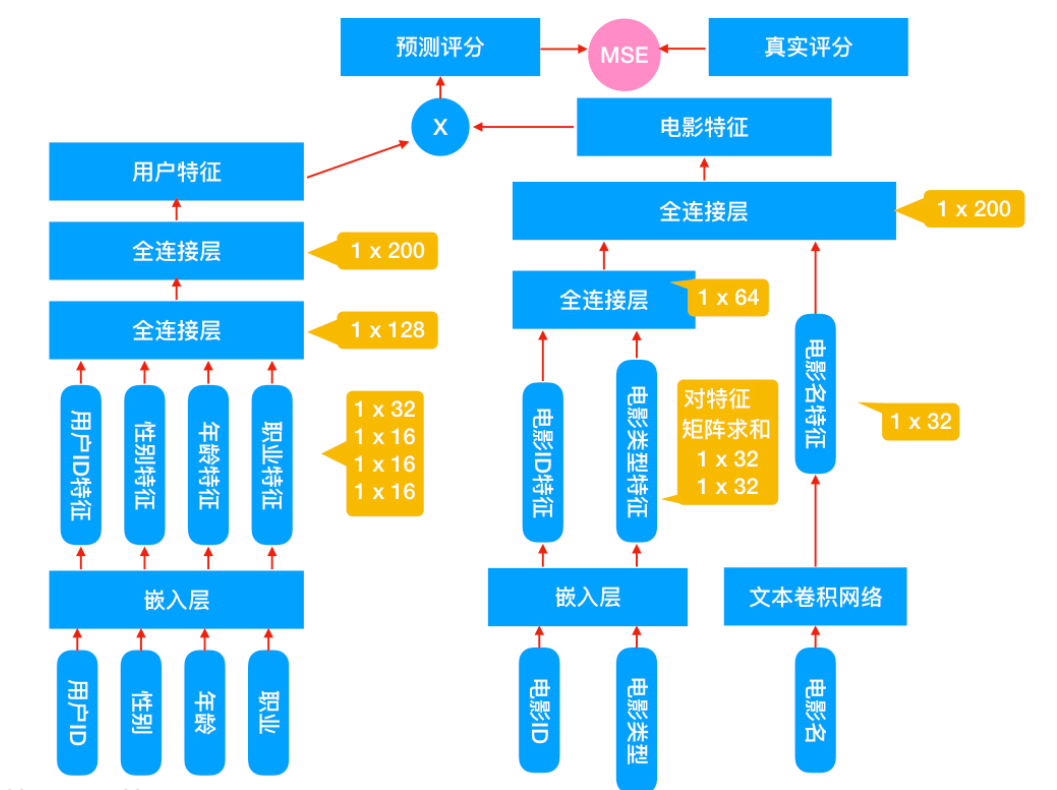

通过研究数据集中的字段类型，我们发现有一些是类别字段，通常的处理是将这些字段转成one hot编码，但是像UserID、MovieID这样的字段就会变成非常的稀疏，输入的维度急剧膨胀，这是我们不愿意见到的，毕竟我这小笔记本不像大厂动辄能处理数以亿计维度的输入：）

**预处理数据时**

* 将UserID、MovieID转成了数字，我们用这个数字当做嵌入矩阵的索引，在网络的第一层使用了嵌入层，维度是（N，32）和（N，16）。

* 电影类型的处理要多一步，有时一个电影有多个电影类型，这样从嵌入矩阵索引出来是一个（n，32）的矩阵，因为有多个类型嘛，我们要将这个矩阵求和，变成（1，32）的向量。

* 电影名的处理比较特殊，没有使用循环神经网络，而是用了文本卷积网络，下文会进行说明。

**简单模型设计**

从嵌入层索引出特征以后，将各特征传入全连接层，将输出再次传入全连接层

最终分别得到（1，200）的用户特征和电影特征两个特征向量。

****

我们的目的就是要训练出用户特征和电影特征，在实现推荐功能时使用。得到这两个特征以后，就可以选择任意的方式来拟合评分了。
我使用了两种方式，一个是上图中画出的将两个特征做向量乘法，将结果与真实评分做回归，采用MSE优化损失。因为本质上这是一个回归问题

另一种方式是，将两个特征作为输入，再次传入全连接层，输出一个值，将输出值回归到真实评分，采用MSE优化损失。

实际上第二个方式的MSE loss在0.8附近，第一个方式在1附近，5次迭代的结果。

### 嵌入矩阵 Embedding matrix

Word2Vec词嵌入矩阵：基于神经网络来训练得到的，每个词拥有一个向量来表征它，词和词之间可以通过向量来求相似性，并且向量是非离散的

初始化：
例如对于userid 有m个user
随机生成一个m*n维的矩阵，数字大小-1~1随机初始化

对于第i个人，对应到矩阵里的第i行作为嵌入向量embedding向量（相当于用一个向量代表一个user）


### 文本卷积网络
网络看起来像下面这样

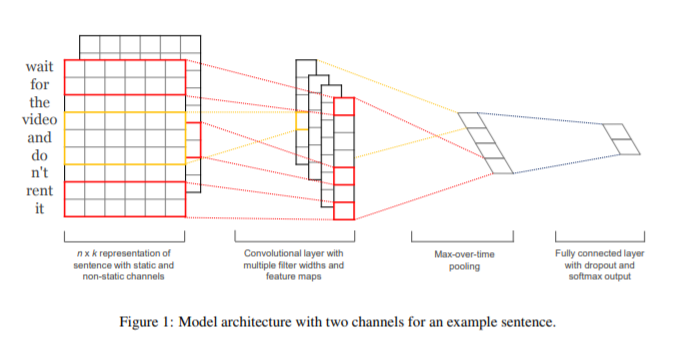<img src="assets/text_cnn.png"/>
图片来自Kim Yoon的论文：[`Convolutional Neural Networks for Sentence Classification`](https://arxiv.org/abs/1408.5882)

将卷积神经网络用于文本的文章建议你阅读[`Understanding Convolutional Neural Networks for NLP`](http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/)

网络的第一层是词嵌入层，由每一个单词的嵌入向量组成的嵌入矩阵。下一层使用多个不同尺寸（窗口大小）的卷积核在嵌入矩阵上做卷积，窗口大小指的是每次卷积覆盖几个单词。这里跟对图像做卷积不太一样，图像的卷积通常用2x2、3x3、5x5之类的尺寸，而文本卷积要覆盖整个单词的嵌入向量，所以尺寸是（单词数，向量维度），比如每次滑动3个，4个或者5个单词。第三层网络是max pooling得到一个长向量，最后使用dropout做正则化，最终得到了电影Title的特征。

## 辅助函数

In [31]:
import tensorflow as tf
import os
import pickle

def save_params(params):
    """
    Save parameters to file
    将结果数据流写入到文件对象中
    """
    pickle.dump(params, open('params.p', 'wb'))


def load_params():
    """
    Load parameters from file
    读取结果数据流
    """
    return pickle.load(open('params.p', mode='rb'))


## 编码实现

In [32]:
#嵌入矩阵的维度
embed_dim = 32
#用户ID个数
uid_max = max(features.take(0,1)) + 1 # 6040
#性别个数
gender_max = max(features.take(2,1)) + 1 # 1 + 1 = 2
#年龄类别个数
age_max = max(features.take(3,1)) + 1 # 6 + 1 = 7
#职业个数
job_max = max(features.take(4,1)) + 1# 20 + 1 = 21

#电影ID个数
movie_id_max = max(features.take(1,1)) + 1 # 3952
#电影类型个数
movie_categories_max = max(genres2int.values()) + 1 # 18 + 1 = 19
#电影名单词个数
movie_title_max = len(title_set) # 5216

#对电影类型嵌入向量做加和操作的标志，考虑过使用mean做平均，但是没实现mean
combiner = "sum"

#电影名长度
sentences_size = title_count # = 15
#文本卷积滑动窗口，分别滑动2, 3, 4, 5个单词
window_sizes = {2, 3, 4, 5}
#文本卷积核数量
filter_num = 8

#电影ID转下标的字典，数据集中电影ID跟下标不一致，比如第5行的数据电影ID不一定是5
movieid2idx = {val[0]:i for i, val in enumerate(movies.values)}

### 超参

In [33]:
# Number of Epochs
num_epochs = 5
# Batch Size
batch_size = 256

dropout_keep = 0.5
# Learning Rate
learning_rate = 0.0001
# Show stats for every n number of batches
show_every_n_batches = 20

save_dir = './save'

### 输入

定义输入的占位符

In [34]:
#生成基于占位符
#[None, 1]默认输入任意数*1维的数据
def get_inputs():
    #tf.placeholder(dtype, shape=None, name=None)
    uid = tf.placeholder(tf.int32, [None, 1], name="uid") 
    movie_id = tf.placeholder(tf.int32, [None, 1], name="movie_id")
    movie_categories = tf.placeholder(tf.int32, [None, 18], name="movie_categories")
    movie_titles = tf.placeholder(tf.int32, [None, 15], name="movie_titles")
    targets = tf.placeholder(tf.int32, [None, 1], name="targets")
    LearningRate = tf.placeholder(tf.float32, name = "LearningRate")
    dropout_keep_prob = tf.placeholder(tf.float32, name = "dropout_keep_prob")
    return uid, movie_id, movie_categories, movie_titles, targets, LearningRate, dropout_keep_prob

## 构建神经网络

#### 定义User的嵌入矩阵

In [35]:
#输入userid （6039）[None, 1]
#返回对应id随机生成的嵌入向量embedding（32）
def get_user_embedding(uid):
    with tf.name_scope("user_embedding"):
        #tf.name_scope命名一个作用域
        #可以让变量有相同的命名，只是限于tf.Variable的变量
        uid_embed_matrix = tf.Variable(tf.random_uniform([uid_max, embed_dim], -1, 1), name = "uid_embed_matrix")
        #返回user人数*对应嵌入矩阵维度的矩阵（6040*32）
        #产生于-1和1之间，产生的值是均匀分布的。
        #对userid进行嵌入向量处理     
        uid_embed_layer = tf.nn.embedding_lookup(uid_embed_matrix, uid, name = "uid_embed_layer")
        #tf.nn.embedding_lookup函数的用法主要是选取一个张量里面索引对应的元素
        #将生成的Variable常数矩阵输入，将uid与矩阵里的第i行的元素相对应相对应
    return uid_embed_layer

#### 将User的嵌入矩阵一起全连接生成User的特征

In [36]:
#将useri的嵌入向量输（32）
#输出特征向量，和特征向量经过200维输出平整化（200）
def get_user_feature_layer(uid_embed_layer):
    with tf.name_scope("user_fc"):
        #第一层全连接，设定激活函数维relu
        #对应大小维uid_embed_layer, embed_dim
        uid_fc_layer = tf.layers.dense(uid_embed_layer, embed_dim, name = "uid_fc_layer", activation=tf.nn.relu)
        #全连接层全连接层的每一个结点都与上一层的所有结点相连
        #输入useid的嵌入向量（32），输出维度为嵌入矩阵的维度（32）
        
        #第二层全连接
        #激活函数采用tanh与-1到1对应
        user_combine_layer = tf.contrib.layers.fully_connected(uid_fc_layer, 200, tf.tanh)  #(?, 1, 200)
        #输入为上一层全连接层的输入（32），输出200维特征向量
        
        #两种类型本质上是相同的tf.contrib.layers.fully_connected和tf.layers.dense，后者称之为前者。然而，除了Keras之外，tf.contrib.fully_connected还增加了一些功能dense，特别是在参数中传递归一化和激活的可能性
    
        user_combine_layer_flat = tf.reshape(user_combine_layer, [-1, 200])
        #reshape确认输出层大小维
        #-1，就是缺省值，数字由其他定，总数除以其他几个的乘积，
    return user_combine_layer, user_combine_layer_flat

#### 定义Movie ID的嵌入矩阵

In [37]:
#对应movieid采用和userid 相同的方法（3952） [None, 1]
#输入movieid 的索引
#对应movie的嵌入向量（32）
def get_movie_id_embed_layer(movie_id):
    with tf.name_scope("movie_embedding"):
        movie_id_embed_matrix = tf.Variable(tf.random_uniform([movie_id_max, embed_dim], -1, 1), name = "movie_id_embed_matrix")
        movie_id_embed_layer = tf.nn.embedding_lookup(movie_id_embed_matrix, movie_id, name = "movie_id_embed_layer")
    return movie_id_embed_layer

#### 对电影类型的多个嵌入向量做加和

In [38]:
a = np.array([[1,2,3],[2,3,4]])
a

array([[1, 2, 3],
       [2, 3, 4]])

In [39]:
a.shape

(2, 3)

In [40]:
a.sum(axis=0,keepdims=True).shape

(1, 3)

**对axis=1的简单理解，对应axis=i,就会将shape的第i个形状参数置为1**
axis=0按列操作
axis=1按行操作

In [41]:
#对电影类型的处理
#输入电影类型属性（18类）[None, 18]
#输出对应属性的嵌入向量（None, 1，32）
def get_movie_categories_layers(movie_categories):
    with tf.name_scope("movie_categories_layers"):
        movie_categories_embed_matrix = tf.Variable(tf.random_uniform([movie_categories_max, embed_dim], -1, 1), name = "movie_categories_embed_matrix")
        #电影类型嵌入矩阵
        #movie_categories_max* embed_dim ，电影类型的属性向量（18）*嵌入矩阵维度（32）
        movie_categories_embed_layer = tf.nn.embedding_lookup(movie_categories_embed_matrix, movie_categories, name = "movie_categories_embed_layer")
        #从movie_categories_embed_matrix矩阵中抽取对应movie_categories(n, 18)的嵌入向量（n,18,  32）
        #tf.nn.embedding_lookup理论上应该对应[None, 18]=[ [18个数字]]
        if combiner == "sum":
            movie_categories_embed_layer = tf.reduce_sum(movie_categories_embed_layer, axis=1, keep_dims=True)
        #对代表一个类型的嵌入向量求和movie_categories_embed_layer，将属性值对应的
        #嵌入矩阵索引出来是一个（n，32）的矩阵，因为有多个类型嘛，我们要将这个矩阵求和，变成（n, 1，32）的向量。
        #axis=1是对应第n个18维相加
    #     elif combiner == "mean":

    return movie_categories_embed_layer

** 占位符(分解认识)**

In [42]:
#tf.nn.embedding_lookup测试
t = tf.placeholder(tf.int32, [None, 5])

c =   tf.Variable(tf.random_uniform([5, 3], -1, 1))

b = tf.nn.embedding_lookup(c,t)
d = tf.reduce_sum(b, axis=1, keep_dims=True)
 
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    print(sess.run(b, feed_dict={t: [[1,2,0,0,0]]}))
    print("====")
    print(sess.run(c))
    print("====")
    print(sess.run(d, feed_dict={t: [[1,2,0,0,0]]}))

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use `tf.global_variables_initializer` instead.
[[[-0.92541075 -0.7655592   0.07017684]
  [ 0.84239125 -0.2345376   0.5002718 ]
  [-0.07166004  0.5848782  -0.84181666]
  [-0.07166004  0.5848782  -0.84181666]
  [-0.07166004  0.5848782  -0.84181666]]]
====
[[-0.07166004  0.5848782  -0.84181666]
 [-0.92541075 -0.7655592   0.07017684]
 [ 0.84239125 -0.2345376   0.5002718 ]
 [-0.6961844  -0.0888288  -0.17667103]
 [ 0.6390643  -0.65862226 -0.1552031 ]]
====
[[[-0.29799962  0.7545378  -1.9550014 ]]]


#### Movie Title的文本卷积网络实现

In [43]:
#文本处理
#输入电影标题的文字list
#输出对应经过文字卷积处理的1*1*32向量
def get_movie_cnn_layer(movie_titles):
    #从嵌入矩阵中得到电影名对应的各个单词的嵌入向量
    with tf.name_scope("movie_embedding"):
        movie_title_embed_matrix = tf.Variable(tf.random_uniform([movie_title_max, embed_dim], -1, 1), name = "movie_title_embed_matrix")
        #电影标题title单词出现中类（5216）*嵌入维度（32）
        movie_title_embed_layer = tf.nn.embedding_lookup(movie_title_embed_matrix, movie_titles, name = "movie_title_embed_layer")
        #对应标题文字，对应的标题嵌入词向量（None, 15, 32）
        movie_title_embed_layer_expand = tf.expand_dims(movie_title_embed_layer, -1)
        #在第axis位置增加一个维度，在后面加上一个维度（None, 15, 32, 1）
    
    #对文本嵌入层使用不同尺寸的卷积核做卷积和最大池化
    #文本嵌入层输入一个（32，1）维的嵌入向量
    pool_layer_lst = []
    for window_size in window_sizes:
        # window_sizes分别以{2, 3, 4, 5}
        #每次滑动2， 3个，4个或者5个单词
        with tf.name_scope("movie_txt_conv_maxpool_{}".format(window_size)):
            filter_weights = tf.Variable(tf.truncated_normal([window_size, embed_dim, 1, filter_num],stddev=0.1),name = "filter_weights")
            #生成卷积核的权重（正太分布随机初始化卷积核权重）
            #tf.truncated_normal(shape, mean=0.0, stddev=1.0, dtype=tf.float32, seed=None, name=None)
            #mean: 正态分布的均值（默认为0）。stddev: 正态分布的标准差。
            #[window_size, embed_dim, 1, filter_num]=shape对应输出的张量大小为window_size（2/3/4/5）*embed_dim（32）*1*filter_num（8）
            #从截断的正态分布中输出随机值。 生成的值服从具有指定平均值和标准偏差的正态分布，如果生成的值大于平均值2个标准偏差的值则丢弃重新选择。
            filter_bias = tf.Variable(tf.constant(0.1, shape=[filter_num]), name="filter_bias")
            #生成卷积核的偏差shape=[filter_num]对应卷积核数量=8
            #当window_size=2
            #对2*32*1*8
            
            conv_layer = tf.nn.conv2d(movie_title_embed_layer_expand, filter_weights, [1,1,1,1], padding="VALID", name="conv_layer")
            #tf.nn.conv2d实现卷积
            #tf.nn.conv2d(input, filter, strides, padding, use_cudnn_on_gpu=None, name=None)
            #输入movie_title_embed_layer_expand，电影文字的32维嵌入向量（None, 15, 32, 1）
            #filter_weights卷积核权重， 例如2*32*1*8
            #strides=[1,1,1,1]：卷积时在图像每一维的步长，这是一个一维的向量，长度4、、
            #conv_layer 输出维度维
            #（None, 15, 32, 1）卷积2*32*1*8 padding="VALID"输出14*1*1*8（filter）
            #（None, 15, 32, 1）卷积3*32*1*8 padding="VALID"输出13*1*1*8（filter）
            
            relu_layer = tf.nn.relu(tf.nn.bias_add(conv_layer,filter_bias), name ="relu_layer")
            #conv_layer加上偏差和激活函数relu
            
            maxpool_layer = tf.nn.max_pool(relu_layer, [1,sentences_size - window_size + 1 ,1,1], [1,1,1,1], padding="VALID", name="maxpool_layer")
            #最大池化
            #"VALID" = without padding:不在卷积边缘扩充
            #[1,sentences_size（15）- window_size（2） + 1 ,1,1]
             #14*1*1*8池化卷积1*14*1*1 输出1*1*1*8
            
            pool_layer_lst.append(maxpool_layer)
        #pool_layer_lst为对应window_sizes分别以{2, 3, 4, 5}的层的集合，输出1*1*1*8

    #Dropout层（过拟合）
    with tf.name_scope("pool_dropout"):
        pool_layer = tf.concat(pool_layer_lst, 3, name ="pool_layer")
        # tf.concat(values, axis,name='concat)values应该是一个tensor的list或者tuple。axis则是我们想要连接的维度。
        #对应第三个维度将由window_sizes分别以{2, 3, 4, 5}输出的1*1*1*8相连接的1*1*4*8
        
        max_num = len(window_sizes) * filter_num#4*8的矩阵
        pool_layer_flat = tf.reshape(pool_layer , [-1, 1, max_num], name = "pool_layer_flat") #fallten归一化1*1*32
    
        dropout_layer = tf.nn.dropout(pool_layer_flat, dropout_keep_prob, name = "dropout_layer") #以dropout_keep_prob概率进行dropout
        #每个神经元都要参加运算，但其输出要乘以概率p
    return pool_layer_flat, dropout_layer

#### 将Movie的各个层一起做全连接

In [44]:
#电影id的对应嵌入向量
#经过两层全连接层
#输出电影对应的200维特征向量
def get_movie_feature_layer(movie_id_embed_layer):
    with tf.name_scope("movie_fc"):
        #第一层全连接
        movie_id_fc_layer = tf.layers.dense(movie_id_embed_layer, embed_dim, name = "movie_id_fc_layer", activation=tf.nn.relu)

        #第二层全连接
        movie_combine_layer = tf.contrib.layers.fully_connected(movie_id_fc_layer, 200, tf.tanh)  #(?, 1, 200)
    
        movie_combine_layer_flat = tf.reshape(movie_combine_layer, [-1, 200])
    return movie_combine_layer, movie_combine_layer_flat

## 构建计算图

In [45]:
#利用tf.reset_default_graph()重置清空default graph计算图以及nodes节点
tf.reset_default_graph()

#声明一个计算图
train_graph = tf.Graph()
with train_graph.as_default():
    #获取输入占位符
    uid, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob = get_inputs()
    ##返回对应id随机生成的嵌入向量embedding（32）
    uid_embed_layer = get_user_embedding(uid)
    #得到对应id的用户特征
    user_combine_layer, user_combine_layer_flat = get_user_feature_layer(uid_embed_layer)
    #获取电影ID的嵌入向量（32）
    movie_id_embed_layer = get_movie_id_embed_layer(movie_id)
    
#     获取电影类型的嵌入向量
#     movie_categories_embed_layer = get_movie_categories_layers(movie_categories)
#     获取电影名的特征向量
#     pool_layer_flat, dropout_layer = get_movie_cnn_layer(movie_titles)
    
    #得到电影特征输出电影对应的200维特征向量
    movie_combine_layer, movie_combine_layer_flat = get_movie_feature_layer(movie_id_embed_layer)
    
    
    #计算出评分，要注意两个不同的方案，inference的名字（name值）是不一样的，后面做推荐时要根据name取得tensor
    with tf.name_scope("inference"):
        #将用户特征和电影特征作为输入，经过全连接，输出一个值的方案
#         inference_layer = tf.concat([user_combine_layer_flat, movie_combine_layer_flat], 1)  #(?, 200)
#         inference = tf.layers.dense(inference_layer, 1,
#                                     kernel_initializer=tf.truncated_normal_initializer(stddev=0.01), 
#                                     kernel_regularizer=tf.nn.l2_loss, name="inference")
        #简单的将用户特征和电影特征做矩阵乘法得到一个预测评分
#        inference = tf.matmul(user_combine_layer_flat, tf.transpose(movie_combine_layer_flat))
        inference = tf.reduce_sum(user_combine_layer_flat * movie_combine_layer_flat, axis=1) #直接相乘
        # #得到对应id的用户特征200维*得到电影特征输出电影对应的200维特征向量
        inference = tf.expand_dims(inference, axis=1)
        #在第axis=1位置增加一个维度

    with tf.name_scope("loss"):
        # MSE损失，将计算值回归到评分
        cost = tf.losses.mean_squared_error(targets, inference )
        loss = tf.reduce_mean(cost)
        #loss详见求平均
    # 优化损失 
#     train_op = tf.train.AdamOptimizer(lr).minimize(loss)  #cost
    global_step = tf.Variable(0, name="global_step", trainable=False)
    optimizer = tf.train.AdamOptimizer(lr)
    #lr= 0.11的Adam优化算法：是一个寻找全局最优点的优化算法，引入了二次方梯度校正。优化器
    gradients = optimizer.compute_gradients(loss)  
    #对var_list中的变量计算loss的梯度该函数为函数minimize()的第一部分，返回一个以元组(gradient, variable)组成的列表
    #optimize， 计算cost中可训练的var_list中的梯度
    train_op = optimizer.apply_gradients(gradients, global_step=global_step)
    #optimize，optimizer.apply_gradients利用梯度进行更新
    #将计算出的梯度应用到变量上，是函数minimize()的第二部分，返回一个应用指定的梯度的操作Operation，对global_step做自增操作
    

## 取得batch

In [46]:
#根据batch分布投入数据训练
def get_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]
        #yield的功能类似于return，但是不同之处在于它返回的是生成器
        #生成器是通过一个或多个yield表达式构成的函数，每一个生成器都是一个迭代器（但是迭代器不一定是生成器）

## 训练网络

In [47]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import time
import datetime

losses = {'train':[], 'test':[]}

with tf.Session(graph=train_graph) as sess:
    #调用设计好的train_graph计算图
    
    #搜集数据给tensorBoard用
    # Keep track of gradient values and sparsity
    grad_summaries = []
    for g, v in gradients: #读取梯度，gradients维返回一个以元组(gradient, variable)组成的列表
        if g is not None: #如果梯度存在， 
            grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name.replace(':', '_')), g)
            #tf.summary.histogram(): 输出一个直方图的Summary protocol buffer .将梯度输出为直方图，
            sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name.replace(':', '_')), tf.nn.zero_fraction(g))
            #将输入的Tensor中0元素在所有元素中所占的比例计算并返回，因为relu激活函数有时会大面积的将输入参数设为0，所以此函数可以有效衡量relu激活函数的有效性
            #tf.summary.scalar用来显示标量信息
            grad_summaries.append(grad_hist_summary)
            grad_summaries.append(sparsity_summary)
    grad_summaries_merged = tf.summary.merge(grad_summaries)
        
        
    # Output directory for models and summaries
    timestamp = str(int(time.time()))
    out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))#对应时间的文件写入
    print("Writing to {}\n".format(out_dir))#写入文件到。。。
     
    # Summaries for loss and accuracy
    loss_summary = tf.summary.scalar("loss", loss)
    ##tf.summary.scalar用来显示标量信息

    # Train Summaries训练集
    train_summary_op = tf.summary.merge([loss_summary, grad_summaries_merged])
    train_summary_dir = os.path.join(out_dir, "summaries", "train")
    train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

    # Inference summaries测试集
    inference_summary_op = tf.summary.merge([loss_summary])
    inference_summary_dir = os.path.join(out_dir, "summaries", "inference")
    inference_summary_writer = tf.summary.FileWriter(inference_summary_dir, sess.graph)

    
    
    sess.run(tf.global_variables_initializer())#初始化模型的参数
    saver = tf.train.Saver()
    for epoch_i in range(num_epochs):
        
        #将数据集分成训练集和测试集，随机种子不固定
        train_X,test_X, train_y, test_y = train_test_split(features,  
                                                           targets_values,  
                                                           test_size = 0.2,  
                                                           random_state = 0)  
        
        #设定训练集和测试集的batch迭代生成器
        train_batches = get_batches(train_X, train_y, batch_size)
        test_batches = get_batches(test_X, test_y, batch_size)
    
        #训练的迭代，保存训练损失
        for batch_i in range(len(train_X) // batch_size):
            x, y = next(train_batches)
            #不断输入batch的数据
            
            #初始化一个batch_size的类别向量
            categories = np.zeros([batch_size, 18])
            for i in range(batch_size):
                categories[i] = x.take(6,1)[i]
                #axis = 1 对用按索引axis
                #对每一个向量设定提取指定索引位置的数据,并以一维数组或者矩阵返回(主要取决axis)
                #类别向量对应特征的第6列

            titles = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]
                #titles对应特征第5列

            feed = {
                uid: np.reshape(x.take(0,1), [batch_size, 1]),
                movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                movie_categories: categories,  #x.take(6,1)
                movie_titles: titles,  #x.take(5,1)
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: dropout_keep, #dropout_keep
                lr: learning_rate}

            step, train_loss, summaries, _ = sess.run([global_step, loss, train_summary_op, train_op], feed)  #cost
            #loss
            #global_step次数
            #train_summary_op = tf.summary.merge([loss_summary, grad_summaries_merged])loss，梯度，
            # train_op = optimizer.apply_gradients(gradients, global_step=global_step)优化器将梯度进行训练的值
            losses['train'].append(train_loss)
            #train_loss将每一次batch_i的loss存储
            train_summary_writer.add_summary(summaries, step)  #
            
            # Show every <show_every_n_batches> batches
            if (epoch_i * (len(train_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                time_str = datetime.datetime.now().isoformat()
                print('{}: Epoch {:>3} Batch {:>4}/{}   train_loss = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(train_X) // batch_size),
                    train_loss))
                
        #使用测试数据的迭代
        for batch_i  in range(len(test_X) // batch_size):
            x, y = next(test_batches)
            
            categories = np.zeros([batch_size, 18])
            for i in range(batch_size):
                categories[i] = x.take(6,1)[i] 
            #categories类别属性向量

            titles = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]
          

            feed = {
                uid: np.reshape(x.take(0,1), [batch_size, 1]),
                movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                movie_categories: categories,  #x.take(6,1)
                movie_titles: titles,  #x.take(5,1)
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: 1,
                lr: learning_rate}
            
            step, test_loss, summaries = sess.run([global_step, loss, inference_summary_op], feed)  #cost

            #保存测试损失
            losses['test'].append(test_loss)
            inference_summary_writer.add_summary(summaries, step)  #

            time_str = datetime.datetime.now().isoformat()
            if (epoch_i * (len(test_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                print('{}: Epoch {:>3} Batch {:>4}/{}   test_loss = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(test_X) // batch_size),
                    test_loss))

    # Save Model
    saver.save(sess, save_dir)  #, global_step=epoch_i
    print('Model Trained and Saved')


Writing to C:\Users\tree\PycharmProjects\recommendation\SecondWeek1202\runs\1544253954

2018-12-08T15:25:56.328152: Epoch   0 Batch    0/3125   train_loss = 13.566
2018-12-08T15:25:56.650505: Epoch   0 Batch   20/3125   train_loss = 10.295
2018-12-08T15:25:56.980273: Epoch   0 Batch   40/3125   train_loss = 7.102
2018-12-08T15:25:57.300651: Epoch   0 Batch   60/3125   train_loss = 4.327
2018-12-08T15:25:57.630249: Epoch   0 Batch   80/3125   train_loss = 3.053
2018-12-08T15:25:57.960353: Epoch   0 Batch  100/3125   train_loss = 2.444
2018-12-08T15:25:58.280442: Epoch   0 Batch  120/3125   train_loss = 2.350
2018-12-08T15:25:58.600715: Epoch   0 Batch  140/3125   train_loss = 2.500
2018-12-08T15:25:58.930528: Epoch   0 Batch  160/3125   train_loss = 1.893
2018-12-08T15:25:59.251923: Epoch   0 Batch  180/3125   train_loss = 2.005
2018-12-08T15:25:59.570326: Epoch   0 Batch  200/3125   train_loss = 2.246
2018-12-08T15:25:59.917268: Epoch   0 Batch  220/3125   train_loss = 1.964
2018-12-08

2018-12-08T15:26:31.749590: Epoch   0 Batch 2160/3125   train_loss = 1.157
2018-12-08T15:26:32.085066: Epoch   0 Batch 2180/3125   train_loss = 1.186
2018-12-08T15:26:32.410617: Epoch   0 Batch 2200/3125   train_loss = 1.075
2018-12-08T15:26:32.740788: Epoch   0 Batch 2220/3125   train_loss = 1.251
2018-12-08T15:26:33.049255: Epoch   0 Batch 2240/3125   train_loss = 1.051
2018-12-08T15:26:33.380758: Epoch   0 Batch 2260/3125   train_loss = 1.156
2018-12-08T15:26:33.704339: Epoch   0 Batch 2280/3125   train_loss = 1.132
2018-12-08T15:26:34.034741: Epoch   0 Batch 2300/3125   train_loss = 1.156
2018-12-08T15:26:34.360774: Epoch   0 Batch 2320/3125   train_loss = 1.225
2018-12-08T15:26:34.680534: Epoch   0 Batch 2340/3125   train_loss = 1.120
2018-12-08T15:26:35.020430: Epoch   0 Batch 2360/3125   train_loss = 1.155
2018-12-08T15:26:35.351484: Epoch   0 Batch 2380/3125   train_loss = 1.027
2018-12-08T15:26:35.684834: Epoch   0 Batch 2400/3125   train_loss = 1.204
2018-12-08T15:26:36.02074

2018-12-08T15:27:01.068985: Epoch   1 Batch  435/3125   train_loss = 1.205
2018-12-08T15:27:01.397806: Epoch   1 Batch  455/3125   train_loss = 1.034
2018-12-08T15:27:01.710515: Epoch   1 Batch  475/3125   train_loss = 1.182
2018-12-08T15:27:02.029350: Epoch   1 Batch  495/3125   train_loss = 1.004
2018-12-08T15:27:02.360417: Epoch   1 Batch  515/3125   train_loss = 1.115
2018-12-08T15:27:02.680365: Epoch   1 Batch  535/3125   train_loss = 1.098
2018-12-08T15:27:03.020552: Epoch   1 Batch  555/3125   train_loss = 1.214
2018-12-08T15:27:03.331242: Epoch   1 Batch  575/3125   train_loss = 1.149
2018-12-08T15:27:03.664431: Epoch   1 Batch  595/3125   train_loss = 1.220
2018-12-08T15:27:03.986244: Epoch   1 Batch  615/3125   train_loss = 1.060
2018-12-08T15:27:04.310306: Epoch   1 Batch  635/3125   train_loss = 1.104
2018-12-08T15:27:04.633266: Epoch   1 Batch  655/3125   train_loss = 1.009
2018-12-08T15:27:04.950508: Epoch   1 Batch  675/3125   train_loss = 0.834
2018-12-08T15:27:05.29043

2018-12-08T15:27:36.610480: Epoch   1 Batch 2615/3125   train_loss = 1.121
2018-12-08T15:27:36.933770: Epoch   1 Batch 2635/3125   train_loss = 0.895
2018-12-08T15:27:37.250258: Epoch   1 Batch 2655/3125   train_loss = 1.021
2018-12-08T15:27:37.580405: Epoch   1 Batch 2675/3125   train_loss = 0.910
2018-12-08T15:27:37.908226: Epoch   1 Batch 2695/3125   train_loss = 1.042
2018-12-08T15:27:38.230648: Epoch   1 Batch 2715/3125   train_loss = 0.936
2018-12-08T15:27:38.554355: Epoch   1 Batch 2735/3125   train_loss = 0.883
2018-12-08T15:27:38.880323: Epoch   1 Batch 2755/3125   train_loss = 0.975
2018-12-08T15:27:39.200412: Epoch   1 Batch 2775/3125   train_loss = 1.023
2018-12-08T15:27:39.524862: Epoch   1 Batch 2795/3125   train_loss = 1.072
2018-12-08T15:27:39.850468: Epoch   1 Batch 2815/3125   train_loss = 0.932
2018-12-08T15:27:40.170343: Epoch   1 Batch 2835/3125   train_loss = 1.007
2018-12-08T15:27:40.500534: Epoch   1 Batch 2855/3125   train_loss = 1.021
2018-12-08T15:27:40.82988

2018-12-08T15:28:05.820500: Epoch   2 Batch  910/3125   train_loss = 0.995
2018-12-08T15:28:06.140649: Epoch   2 Batch  930/3125   train_loss = 0.983
2018-12-08T15:28:06.474300: Epoch   2 Batch  950/3125   train_loss = 0.901
2018-12-08T15:28:06.799692: Epoch   2 Batch  970/3125   train_loss = 1.020
2018-12-08T15:28:07.120245: Epoch   2 Batch  990/3125   train_loss = 0.757
2018-12-08T15:28:07.440634: Epoch   2 Batch 1010/3125   train_loss = 1.080
2018-12-08T15:28:07.774557: Epoch   2 Batch 1030/3125   train_loss = 0.883
2018-12-08T15:28:08.099832: Epoch   2 Batch 1050/3125   train_loss = 0.899
2018-12-08T15:28:08.420325: Epoch   2 Batch 1070/3125   train_loss = 0.926
2018-12-08T15:28:08.750487: Epoch   2 Batch 1090/3125   train_loss = 1.005
2018-12-08T15:28:09.074753: Epoch   2 Batch 1110/3125   train_loss = 1.046
2018-12-08T15:28:09.400750: Epoch   2 Batch 1130/3125   train_loss = 0.868
2018-12-08T15:28:09.720632: Epoch   2 Batch 1150/3125   train_loss = 0.916
2018-12-08T15:28:10.04443

2018-12-08T15:28:41.593577: Epoch   2 Batch 3090/3125   train_loss = 0.730
2018-12-08T15:28:41.913503: Epoch   2 Batch 3110/3125   train_loss = 0.815
2018-12-08T15:28:42.290214: Epoch   2 Batch   18/781   test_loss = 0.778
2018-12-08T15:28:42.440671: Epoch   2 Batch   38/781   test_loss = 0.848
2018-12-08T15:28:42.594470: Epoch   2 Batch   58/781   test_loss = 0.823
2018-12-08T15:28:42.737486: Epoch   2 Batch   78/781   test_loss = 0.851
2018-12-08T15:28:42.880396: Epoch   2 Batch   98/781   test_loss = 0.859
2018-12-08T15:28:43.020635: Epoch   2 Batch  118/781   test_loss = 0.888
2018-12-08T15:28:43.160608: Epoch   2 Batch  138/781   test_loss = 0.980
2018-12-08T15:28:43.301827: Epoch   2 Batch  158/781   test_loss = 0.809
2018-12-08T15:28:43.450673: Epoch   2 Batch  178/781   test_loss = 0.813
2018-12-08T15:28:43.590185: Epoch   2 Batch  198/781   test_loss = 0.906
2018-12-08T15:28:43.730691: Epoch   2 Batch  218/781   test_loss = 1.008
2018-12-08T15:28:43.880302: Epoch   2 Batch  23

2018-12-08T15:29:10.970259: Epoch   3 Batch 1385/3125   train_loss = 0.766
2018-12-08T15:29:11.279733: Epoch   3 Batch 1405/3125   train_loss = 0.881
2018-12-08T15:29:11.630204: Epoch   3 Batch 1425/3125   train_loss = 1.023
2018-12-08T15:29:11.954011: Epoch   3 Batch 1445/3125   train_loss = 0.977
2018-12-08T15:29:12.271264: Epoch   3 Batch 1465/3125   train_loss = 0.868
2018-12-08T15:29:12.603594: Epoch   3 Batch 1485/3125   train_loss = 0.878
2018-12-08T15:29:12.925992: Epoch   3 Batch 1505/3125   train_loss = 0.740
2018-12-08T15:29:13.249419: Epoch   3 Batch 1525/3125   train_loss = 0.784
2018-12-08T15:29:13.570595: Epoch   3 Batch 1545/3125   train_loss = 0.857
2018-12-08T15:29:13.890558: Epoch   3 Batch 1565/3125   train_loss = 0.872
2018-12-08T15:29:14.218477: Epoch   3 Batch 1585/3125   train_loss = 0.816
2018-12-08T15:29:14.550355: Epoch   3 Batch 1605/3125   train_loss = 0.825
2018-12-08T15:29:14.884323: Epoch   3 Batch 1625/3125   train_loss = 0.926
2018-12-08T15:29:15.21076

2018-12-08T15:29:42.984738: Epoch   3 Batch  457/781   test_loss = 0.715
2018-12-08T15:29:43.140332: Epoch   3 Batch  477/781   test_loss = 0.855
2018-12-08T15:29:43.294202: Epoch   3 Batch  497/781   test_loss = 0.815
2018-12-08T15:29:43.420657: Epoch   3 Batch  517/781   test_loss = 0.790
2018-12-08T15:29:43.570458: Epoch   3 Batch  537/781   test_loss = 0.851
2018-12-08T15:29:43.730630: Epoch   3 Batch  557/781   test_loss = 0.971
2018-12-08T15:29:43.890490: Epoch   3 Batch  577/781   test_loss = 0.881
2018-12-08T15:29:44.060364: Epoch   3 Batch  597/781   test_loss = 0.803
2018-12-08T15:29:44.210165: Epoch   3 Batch  617/781   test_loss = 0.863
2018-12-08T15:29:44.350178: Epoch   3 Batch  637/781   test_loss = 0.776
2018-12-08T15:29:44.501257: Epoch   3 Batch  657/781   test_loss = 0.950
2018-12-08T15:29:44.650322: Epoch   3 Batch  677/781   test_loss = 0.935
2018-12-08T15:29:44.801628: Epoch   3 Batch  697/781   test_loss = 0.956
2018-12-08T15:29:44.950290: Epoch   3 Batch  717/78

2018-12-08T15:30:16.230148: Epoch   4 Batch 1840/3125   train_loss = 0.893
2018-12-08T15:30:16.550443: Epoch   4 Batch 1860/3125   train_loss = 0.940
2018-12-08T15:30:16.883074: Epoch   4 Batch 1880/3125   train_loss = 0.827
2018-12-08T15:30:17.214357: Epoch   4 Batch 1900/3125   train_loss = 0.750
2018-12-08T15:30:17.541451: Epoch   4 Batch 1920/3125   train_loss = 0.804
2018-12-08T15:30:17.870175: Epoch   4 Batch 1940/3125   train_loss = 0.752
2018-12-08T15:30:18.212132: Epoch   4 Batch 1960/3125   train_loss = 0.753
2018-12-08T15:30:18.530404: Epoch   4 Batch 1980/3125   train_loss = 0.786
2018-12-08T15:30:18.867156: Epoch   4 Batch 2000/3125   train_loss = 0.979
2018-12-08T15:30:19.199411: Epoch   4 Batch 2020/3125   train_loss = 0.890
2018-12-08T15:30:19.513778: Epoch   4 Batch 2040/3125   train_loss = 0.780
2018-12-08T15:30:19.820253: Epoch   4 Batch 2060/3125   train_loss = 0.816
2018-12-08T15:30:20.148906: Epoch   4 Batch 2080/3125   train_loss = 0.972
2018-12-08T15:30:20.47048

## 在 TensorBoard 中查看可视化结果

tensorboard --logdir /PATH_TO_CODE/runs/1513402825/summaries/

tensorboard --logdir=C:\Users\tree\PycharmProjects\recommendation\SecondWeek1202\runs\1544103667\summaries\train
<img src="assets/loss.png"/>

## 保存参数
保存`save_dir` 在生成预测时使用。

In [48]:
save_params((save_dir))

load_dir = load_params()
#  load_params()读取结果数据流

## 显示训练Loss

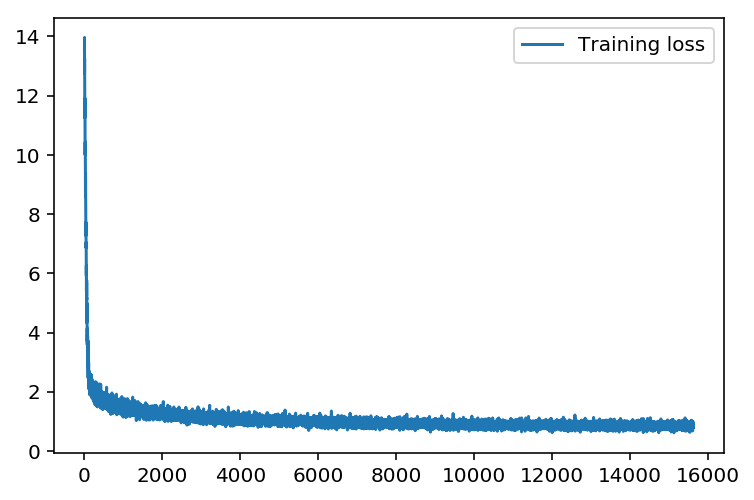

In [49]:
plt.plot(losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

## 显示测试Loss
迭代次数再增加一些，下降的趋势会明显一些

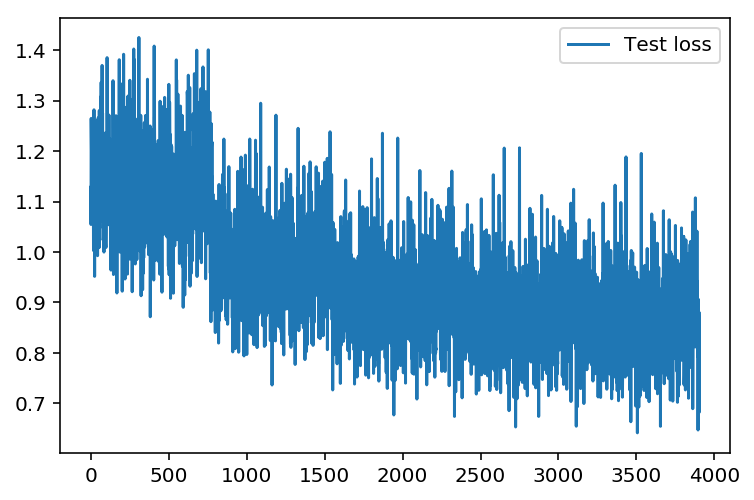

In [50]:
plt.plot(losses['test'], label='Test loss')
plt.legend()
_ = plt.ylim()

## 获取 Tensors
使用函数 [`get_tensor_by_name()`](https://www.tensorflow.org/api_docs/python/tf/Graph#get_tensor_by_name)从 `loaded_graph` 中获取tensors，后面的推荐功能要用到。

In [51]:
def get_tensors(loaded_graph):
    #，就可以使用<name>获取Tensor 
    uid = loaded_graph.get_tensor_by_name("uid:0")
    movie_id = loaded_graph.get_tensor_by_name("movie_id:0")
    movie_categories = loaded_graph.get_tensor_by_name("movie_categories:0")
    movie_titles = loaded_graph.get_tensor_by_name("movie_titles:0")
    targets = loaded_graph.get_tensor_by_name("targets:0")
    dropout_keep_prob = loaded_graph.get_tensor_by_name("dropout_keep_prob:0")
    lr = loaded_graph.get_tensor_by_name("LearningRate:0")
    #两种不同计算预测评分的方案使用不同的name获取tensor inference
#     inference = loaded_graph.get_tensor_by_name("inference/inference/BiasAdd:0")
    inference = loaded_graph.get_tensor_by_name("inference/ExpandDims:0") # 之前是MatMul:0 因为inference代码修改了 这里也要修改 感谢网友 @清歌 指出问题
    #inference = tf.expand_dims(inference, axis=1)
    movie_combine_layer_flat = loaded_graph.get_tensor_by_name("movie_fc/Reshape:0")
    user_combine_layer_flat = loaded_graph.get_tensor_by_name("user_fc/Reshape:0")
    return uid, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, inference, movie_combine_layer_flat, user_combine_layer_flat


## 指定用户和电影进行评分
这部分就是对网络做正向传播，计算得到预测的评分

In [52]:
def rating_movie(user_id_val, movie_id_val):
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model读取保存的模型
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        #读取结果数据流
        loader.restore(sess, load_dir)
    
        # Get Tensors from loaded model
        uid, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, inference,_, __ = get_tensors(loaded_graph)  #loaded_graph
    
        categories = np.zeros([1, 18])#初始化一个属性向量
        categories[0] = movies.values[movieid2idx[movie_id_val]][2]#
        #movieid2idx电影ID转下标的字典 将指定用户id对应下标的movies嵌入值
        #movies 的pandas数据movies.values[2]对应电脑的属性特征
    
        titles = np.zeros([1, sentences_size])
        titles[0] = movies.values[movieid2idx[movie_id_val]][1]
        #对应电脑的标题特征

                    
        feed = {
              uid: np.reshape(users.values[user_id_val-1][0], [1, 1]),
              movie_id: np.reshape(movies.values[movieid2idx[movie_id_val]][0], [1, 1]),
              movie_categories: categories,  #x.take(6,1)
              movie_titles: titles,  #x.take(5,1)
              dropout_keep_prob: 1}
    
        # Get Prediction
        inference_val = sess.run([inference], feed)  
    
        return (inference_val)

In [53]:
movies.values[movieid2idx[1]]

array([1, list([2121, 3945, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
       list([15, 16, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
      dtype=object)

In [54]:
users.values[234]
movies.values[1401]

array([1425, list([3226, 3840, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
       list([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
      dtype=object)

In [55]:
rating_movie(234, 1401)

INFO:tensorflow:Restoring parameters from ./save


[array([[3.5986848]], dtype=float32)]

## 生成Movie特征矩阵
将训练好的电影特征组合成电影特征矩阵并保存到本地

In [56]:
loaded_graph = tf.Graph()  #
movie_matrics = []
with tf.Session(graph=loaded_graph) as sess:  #
    # Load saved model读取保存的模型
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)

    # Get Tensors from loaded model
    uid, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, _, movie_combine_layer_flat, __ = get_tensors(loaded_graph)  #loaded_graph

    for item in movies.values:
        categories = np.zeros([1, 18])
        categories[0] = item.take(2)

        titles = np.zeros([1, sentences_size])
        titles[0] = item.take(1)

        feed = {
            movie_id: np.reshape(item.take(0), [1, 1]),
            movie_categories: categories,  #x.take(6,1)
            movie_titles: titles,  #x.take(5,1)
            dropout_keep_prob: 1}

        movie_combine_layer_flat_val = sess.run([movie_combine_layer_flat], feed)  
        movie_matrics.append(movie_combine_layer_flat_val)

pickle.dump((np.array(movie_matrics).reshape(-1, 200)), open('movie_matrics.p', 'wb'))
movie_matrics = pickle.load(open('movie_matrics.p', mode='rb'))

INFO:tensorflow:Restoring parameters from ./save


In [57]:
movie_matrics = pickle.load(open('movie_matrics.p', mode='rb'))

In [58]:
movie_matrics.shape

(3883, 200)

## 生成User特征矩阵
将训练好的用户特征组合成用户特征矩阵并保存到本地

In [59]:
loaded_graph = tf.Graph()  #
users_matrics = []
with tf.Session(graph=loaded_graph) as sess:  #
    # Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)

    # Get Tensors from loaded model
    uid, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, _, __,user_combine_layer_flat = get_tensors(loaded_graph)  #loaded_graph

    for item in users.values:

        feed = {
            uid: np.reshape(item.take(0), [1, 1]),
            dropout_keep_prob: 1}

        user_combine_layer_flat_val = sess.run([user_combine_layer_flat], feed)  
        users_matrics.append(user_combine_layer_flat_val)

pickle.dump((np.array(users_matrics).reshape(-1, 200)), open('users_matrics.p', 'wb'))
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

INFO:tensorflow:Restoring parameters from ./save


In [60]:
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

In [61]:
users_matrics.shape

(6040, 200)

## 开始推荐电影
使用生产的用户特征矩阵和电影特征矩阵做电影推荐

### 推荐同类型的电影（基于movie）
思路是计算当前看的电影特征向量与整个电影特征矩阵的余弦相似度，取相似度最大的top_k个，这里加了些随机选择在里面，保证每次的推荐稍稍有些不同。

In [62]:
def recommend_same_type_movie(movie_id_val, top_k = 20):
    #电影id ，top取20
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        #读取模型
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
        
        #
        norm_movie_matrics = tf.sqrt(tf.reduce_sum(tf.square(movie_matrics), 1, keep_dims=True))
        #movie_matrics电影特征矩阵
        #tf.squarea里的每一个元素求平方
        #求和(3883, 200) axis=1 ，将特征相加求平方跟
        
        normalized_movie_matrics = movie_matrics / norm_movie_matrics
        #归一化处理

        #推荐同类型的电影
        probs_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200]) #对应电影id对应的嵌入向量
        probs_similarity = tf.matmul(probs_embeddings, tf.transpose(normalized_movie_matrics))
        #矩阵相乘
        #probs_embeddings某个电影id对应嵌入向量
        # tf.transpose(normalized_movie_matrics)为normalized_movie_matrics的转置
        #相乘矩阵结果为对应movie_id_val与矩阵中每一个嵌入向量的像地府
        sim = (probs_similarity.eval())
        #tensor计算
        #使用Tensor.eval()时只能在同一步当中获取一个tensor值
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
        
        print("您看的电影是：{}".format(movies_orig[movieid2idx[movie_id_val]]))
        print("以下是给您的推荐：")
        p = np.squeeze(sim)
        #numpy.squeeze(a,axis = None)从数组的形状中删除单维度条目，即把shape中为1的维度去掉
        # axis的取值可为None 或 int 或 tuple of ints, 可选。若axis为空，则删除所有单维度的条目；
        p[np.argsort(p)[:-top_k]] = 0
        #将x中的元素从小到大排列，提取其对应的index(索引)
        #设定排序将除了topk的全部设为0
        p = p / np.sum(p)
        #相似度归一化
        #加入一些随机选择
        results = set()#生成一个空集合
        while len(results) != 5:
            c = np.random.choice(3883, 1, p=p)[0]
            #以p作为i概率分布随机选择
            results.add(c)
            
        #打印出根据电影推荐的相似电影
        for val in (results):
            print(val)
            print(movies_orig[val])
        
        return results

In [63]:
recommend_same_type_movie(1401, 20)

INFO:tensorflow:Restoring parameters from ./save
您看的电影是：[1401 'Ghosts of Mississippi (1996)' 'Drama']
以下是给您的推荐：
3137
[3206 'Against All Odds (1984)' 'Romance']
234
[237 'Forget Paris (1995)' 'Comedy|Romance']
1379
[1400 'Somebody is Waiting (1996)' 'Drama']
2893
[2962 'Fever Pitch (1997)' 'Comedy|Romance']
3722
[3791 'Footloose (1984)' 'Drama']


{234, 1379, 2893, 3137, 3722}

### 推荐您喜欢的电影（基于users）
思路是使用用户特征向量与电影特征矩阵计算所有电影的评分，取评分最高的top_k个，同样加了些随机选择部分。

In [64]:
def recommend_your_favorite_movie(user_id_val, top_k = 10):

    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)

        #推荐您喜欢的电影
        probs_embeddings = (users_matrics[user_id_val-1]).reshape([1, 200])
        #获得对应user的特征向量

        probs_similarity = tf.matmul(probs_embeddings, tf.transpose(movie_matrics))
        #计算user特征向量与电影特征向量乘积
        sim = (probs_similarity.eval())
    #     print(sim.shape)
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
        
    #     sim_norm = probs_norm_similarity.eval()
    #     print((-sim_norm[0]).argsort()[0:top_k])
    
        print("以下是给您的推荐：")
        #获取对应评分预测最高top
        p = np.squeeze(sim)
        p[np.argsort(p)[:-top_k]] = 0
        p = p / np.sum(p)
        results = set()
        #生成五个推荐
        while len(results) != 5:
            c = np.random.choice(3883, 1, p=p)[0]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])

        return results


In [65]:
recommend_your_favorite_movie(234, 10)

INFO:tensorflow:Restoring parameters from ./save
以下是给您的推荐：
672
[679 'Run of the Country, The (1995)' 'Drama']
49
[50 'Usual Suspects, The (1995)' 'Crime|Thriller']
315
[318 'Shawshank Redemption, The (1994)' 'Drama']
3829
[3899 'Circus (2000)' 'Comedy']
679
[687 'Country Life (1994)' 'Drama|Romance']


{49, 315, 672, 679, 3829}

### 看过这个电影的人还看了（喜欢）哪些电影
- 首先选出喜欢某个电影的top_k个人，得到这几个人的用户特征向量。
- 然后计算这几个人对所有电影的评分
- 选择每个人评分最高的电影作为推荐
- 同样加入了随机选择

In [66]:
import random

def recommend_other_favorite_movie(movie_id_val, top_k = 20):
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)

        probs_movie_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
        probs_user_favorite_similarity = tf.matmul(probs_movie_embeddings, tf.transpose(users_matrics))
        favorite_user_id = np.argsort(probs_user_favorite_similarity.eval())[0][-top_k:]
    #     print(normalized_users_matrics.eval().shape)
    #     print(probs_user_favorite_similarity.eval()[0][favorite_user_id])
    #     print(favorite_user_id.shape)
    
        print("您看的电影是：{}".format(movies_orig[movieid2idx[movie_id_val]]))
        
        print("喜欢看这个电影的人是：{}".format(users_orig[favorite_user_id-1]))
        probs_users_embeddings = (users_matrics[favorite_user_id-1]).reshape([-1, 200])
        probs_similarity = tf.matmul(probs_users_embeddings, tf.transpose(movie_matrics))
        sim = (probs_similarity.eval())
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
    
    #     print(sim.shape)
    #     print(np.argmax(sim, 1))
        p = np.argmax(sim, 1)
        print("喜欢看这个电影的人还喜欢看：")

        results = set()
        while len(results) != 5:
            c = p[random.randrange(top_k)]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])
        
        return results

In [ ]:
recommend_other_favorite_movie(1401, 20)

INFO:tensorflow:Restoring parameters from ./save
您看的电影是：[1401 'Ghosts of Mississippi (1996)' 'Drama']
喜欢看这个电影的人是：[[3833 'M' 25 1]
 [4903 'M' 35 12]
 [277 'F' 35 1]
 [4460 'M' 25 14]
 [2338 'M' 45 17]
 [5461 'M' 50 0]
 [1763 'M' 35 7]
 [3295 'M' 18 18]
 [371 'M' 18 4]
 [102 'M' 35 19]
 [100 'M' 35 17]
 [1745 'M' 45 0]
 [581 'M' 50 14]
 [2693 'M' 56 13]
 [4696 'M' 18 12]
 [4085 'F' 25 6]
 [5861 'F' 50 1]
 [3031 'M' 18 4]
 [4800 'M' 18 4]
 [3901 'M' 18 14]]
喜欢看这个电影的人还喜欢看：


# 结论

以上就是实现的常用的推荐功能，将网络模型作为回归问题进行训练，得到训练好的用户特征矩阵和电影特征矩阵进行推荐。

## 扩展阅读
如果你对个性化推荐感兴趣，以下资料建议你看看：

- [`Understanding Convolutional Neural Networks for NLP`](http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/)

- [`Convolutional Neural Networks for Sentence Classification`](https://github.com/yoonkim/CNN_sentence)

- [`利用TensorFlow实现卷积神经网络做文本分类`](http://www.jianshu.com/p/ed3eac3dcb39?from=singlemessage)

- [`Convolutional Neural Network for Text Classification in Tensorflow`](https://github.com/dennybritz/cnn-text-classification-tf)

- [`SVD Implement Recommendation systems`](https://github.com/songgc/TF-recomm)

今天的分享就到这里，请多指教！